In [1]:
using ReachabilityAnalysis
using MultivariatePolynomials
using LinearAlgebra, SparseArrays
using Plots

const RA = ReachabilityAnalysis
const IA = IntervalArithmetic

# functions for Kronecker powers and sums
using ReachabilityAnalysis: kron_pow, kron_sum, kron_pow_stack

# functions for error bounds
using ReachabilityAnalysis: error_bound_pseries,
                            error_bound_specabs

include("carlin_utils.jl")

┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1278


_solve_CARLIN_resets (generic function with 1 method)

## Theory (1 dimension)

To simplify the presentation we consider the scalar quadratic equation first.

Starting with a nonlinear ODE, we construct a linear ODE in higher dimension.

- The abstraction is exact if the linear system has *infinite* dimensions.
    
- The abstraction is approximate if the linear system is *truncated* to order $N$.

This method is known as Carleman linearization [1].

- [1] Explicit Error Bounds for Carleman Linearization: https://arxiv.org/abs/1711.02552

- [2] Efficient quantum algorithm for dissipative nonlinear differential equations: https://arxiv.org/pdf/2011.03185.pdf

Start with the scalar ODE

$$
x'(t) = ax(t) + bx^2(t), \qquad x(0) = x_0
$$

Introduce auxiliary variables

$y_1 = x$, $y_2 = x^2$, $y_3 = x^3$, $y_4 = x^4$

$y_1' = x' = ax + bx^2 = ay_1 + by_2$

$$
y_2' = 2x' x = 2(ax + bx^2)x = 2(ax^2 + bx^3) = 2ay_2 + 2by_3
$$

$$
y_3' = 3x^2 x' = 3(ax^3 + bx^4) = 3ay_3 + 3by_4
$$

$$
y_4' = 4ay_4 + 4by_5
$$

Note that the structure of the equations is $y'_i = iay_i + iby_{i+1}$ for all $y \geq 1$. Therefore, the nonlinear ODE is (formally) equivalent to an infinite-dimensional linear ODE.

Let's now pick a truncation order $N$ and build a finite-dimensional linear ODE.

Truncation with order $N = 4$

$$
\hat{y}' = \begin{pmatrix}
    a & b & 0 & 0 \\
    0 & 2a & 2b & 0 \\
    0 & 0 & 3a & 3b \\
    0 & 0 & 0 & 4a \\
    \end{pmatrix} \hat{y},\qquad \hat{y}(0) = (x_0, x_0^2, x_0^3, x_0^4)
$$

In [2]:
x0 = 0.79 .. 0.81

[0.789999, 0.810001]

In [3]:
x0^2

[0.624099, 0.656101]

In [4]:
x0^3

[0.493038, 0.531442]

In [5]:
kron_pow(x0, 10)

[0.0946827, 0.121577]

In [6]:
kron_pow_stack(x0, 10)

10-element Array{IntervalArithmetic.Interval{Float64},1}:
 [0.789999, 0.810001]
 [0.624099, 0.656101]
 [0.493038, 0.531442]
 [0.3895, 0.430468]
 [0.307705, 0.348679]
 [0.243087, 0.28243]
 [0.192039, 0.228768]
 [0.15171, 0.185303]
 [0.119851, 0.150095]
 [0.0946827, 0.121577]

This raises the following question: **how do the solutions of the original ODE compare to the solution of the truncated system?**

## Example (logistic differential equation)

Consider the [Logistic differential equation](https://en.wikipedia.org/wiki/Logistic_equation).

$$
\dfrac{du}{dt} = ru(1 - u/K)
$$

- simple model used for various growth scenarios. has analytic solution.

- $r > 0$ controls the initial rate of exponential growth, and $K > 0$ is the asymptotic equilibrium

- move our frame of reference to the asymptotic equilibrium, $v := K - u$ then we obtain

$$
\dfrac{dv}{dt} = -rv + \frac{r}{K}v^2
$$

- let $a = -r$, $b = r/K$

- to choose numerical values that satisfy the spectral absissa criterion, we have that $R < 1$ if and only if $R = |v(0)| (r/K) / (r) < 1$ that is, $|v(0)| < K$

In [7]:
function quadratic(; a, b, N)    
    dl = zeros(N-1)
    d = [a*i for i in 1:N]
    du = [b*i for i in 1:N-1]
    return Tridiagonal(dl, d, du)
end

function logistic(; r, K, N)
    return quadratic(a=-r, b=r/K, N=N)
end

logistic (generic function with 1 method)

In [8]:
a = -1.0 # r = 1
b = 1.0  # K = 1
x0 = 0.8 # x0 = v(0) = |v(0)| = 0.8 < K = 1

A = logistic(r=1.0, K=1.0, N=4)

#=
builds
A = [a  b   0   0;
     0  2a 2b   0;
     0  0  3a  3b;
     0  0   0  4a];
=#

r = -a
K = r / b

F1 = hcat(-r)
F2 = hcat(r/K)

A

4×4 Tridiagonal{Float64,Array{Float64,1}}:
 -1.0   1.0    ⋅     ⋅ 
  0.0  -2.0   2.0    ⋅ 
   ⋅    0.0  -3.0   3.0
   ⋅     ⋅    0.0  -4.0

## Error bounds

In [9]:
N = 4 # truncation order

x0 = Interval(0.6)

# power series
e1 = error_bound_pseries(x0, F1, F2, N=N)

# spectral absissa
e2 = error_bound_specabs(x0, F1, F2, N=N);

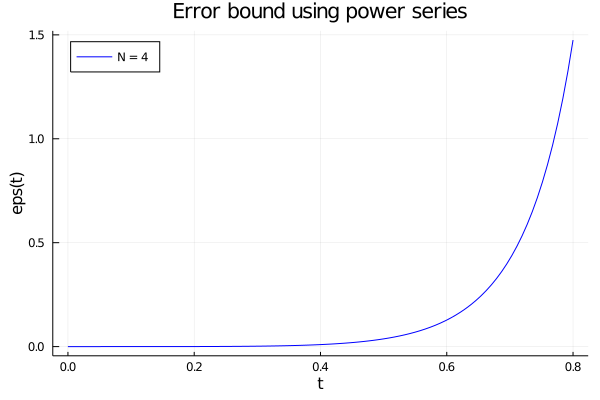

In [10]:
dom = range(0, 0.8, length=100)
plot(dom, e1.(dom), lab="N = $N", c=:blue, legend=:topleft, title="Error bound using power series", xlab="t", ylab="eps(t)")

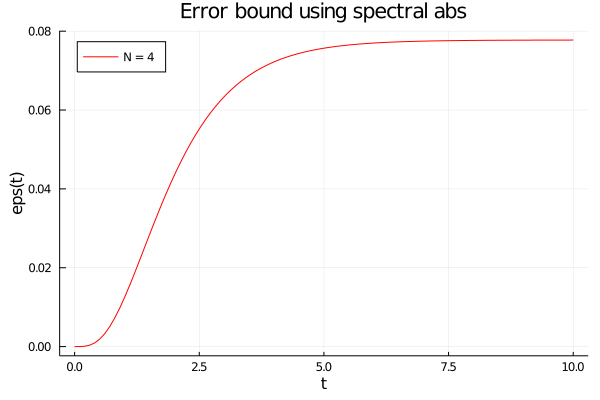

In [11]:
dom = range(0, 10.0, length=100)
plot(dom, e2.(dom), lab="N = $N", c=:red, legend=:topleft, title="Error bound using spectral abs", xlab="t", ylab="eps(t)")

## Comparison for different N

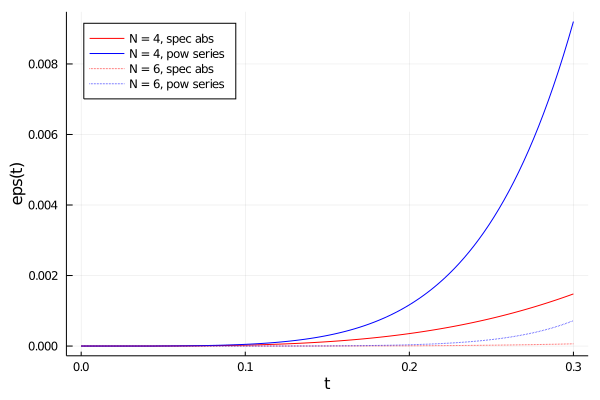

In [12]:
dom = range(0, 0.3, length=100)

N = 4 # truncation order
x0 = Interval(0.8)

# power series
e1 = error_bound_pseries(x0, F1, F2, N=N)

# spectral absissa
e2 = error_bound_specabs(x0, F1, F2, N=N);
plot(dom, e2.(dom), lab="N = $N, spec abs", c=:red, legend=:topleft, title="", xlab="t", ylab="eps(t)")
plot!(dom, e1.(dom), lab="N = $N, pow series", c=:blue, legend=:topleft, title="", xlab="t", ylab="eps(t)")


N = 6 # truncation order
x0 = Interval(0.8)

# power series
e1 = error_bound_pseries(x0, F1, F2, N=N)

# spectral absissa
e2 = error_bound_specabs(x0, F1, F2, N=N);

plot!(dom, e2.(dom), lab="N = $N, spec abs", c=:red, ls=:dot, legend=:topleft, title="", xlab="t", ylab="eps(t)")
plot!(dom, e1.(dom), lab="N = $N, pow series", c=:blue, ls=:dot, legend=:topleft, title="", xlab="t", ylab="eps(t)")

### Interpretation

The error bound using the spectral abs. from https://arxiv.org/pdf/2011.03185.pdf gives a much better error bound under some assumptions.

$$
x'(t) = F_1 x + F_2 (x \otimes x)
$$

where $x = (x_1, x_2, \ldots, x_n)^T$, $x \otimes x = (x_1^2, x_1x_2, x_1x_3, \ldots, x_1x_n, x_2x_1, x_2^2, x_2x_3, \ldots, x_2x_n, \ldots, x_nx_1, x_nx_2,x_nx_3, \ldots, x_n^2)^T$ (Kronecker product) 

- let $R = \dfrac{\Vert u_0 \Vert \Vert F_2 \Vert}{\vert Re(\lambda_1)\vert}$

- we require that $Re(\lambda_n) \leq \cdots \leq Re(\lambda_1) < 0$

- $F_1$ is diagonalizable

- Problems with linear dissipation, $Re(\lambda_1) < 0$ and weak nonlinearity in the sense that

$$
\Vert u_0 \Vert \Vert F_1 \Vert < \vert Re(\lambda_1) \vert,
$$
ie. $R < 1$

Given the asssumptions on $R < 1$ the error bound converges for all $t \geq 0$.

$$
\Vert \varepsilon(t) \Vert = \Vert x_0\Vert R^N (1 - e^{Re(\lambda_1) t})^N
$$
where $R = \dfrac{\Vert x_0 \Vert \Vert F_2 \Vert}{\vert Re(\lambda_1)\vert} $

- Note that for $t \to \infty$, since $Re(\lambda_1) < 0$ then $(1-e^{Re(\lambda_1t)})^N \to 1$ for $t \to \infty$

so $\Vert \varepsilon(t)\Vert \to \Vert x_0 \Vert R^N$ for $ t \to \infty$, and this is also the upper bound on the error.

- Condition $Re(\lambda_1) < 0$ implies $a < 0$

$$
R = \dfrac{\Vert x_0 \Vert \Vert F_2 \Vert}{\vert Re(\lambda_1)\vert} = \dfrac{\vert x_0 \vert \vert b \vert }{\vert a \vert} < 1
$$

Implies $\vert x_0 \vert < \vert a \vert / \vert b \vert$

On the contrary the error bound using the power series summation method is more general (makes n assumption on the spectral absissa) but the error bound is more pessimistic and it has a finite convergence time, ie. only holds for a certain time horizon $0 < t < T^*$ .

## Flowpipe computation

if $x(t)$ denotes the *exact* solution and $\hat{x}(t)$ denotes the solution of the truncated linear system, we know that

$$
\Vert x(t) - \hat{x}(t) \Vert \leq \varepsilon(t) 
$$

$$
x(t) \in \hat{x}(t) \oplus B_\infty(0, \varepsilon(t))
$$

The idea is then to evaluate the error bound for each time span of the solution and take the Minkowski sum with the solution to have a conservative approximation of the exact solution.

In [13]:
A

4×4 Tridiagonal{Float64,Array{Float64,1}}:
 -1.0   1.0    ⋅     ⋅ 
  0.0  -2.0   2.0    ⋅ 
   ⋅    0.0  -3.0   3.0
   ⋅     ⋅    0.0  -4.0

In [14]:
N = 4
x0 = IA.Interval(0.8, 0.8)
ŷ0 = kron_pow_stack(x0, N)
ŷ0 = IntervalBox(ŷ0)
prob = @ivp(ŷ' = Aŷ, ŷ(0) ∈ ŷ0)

InitialValueProblem{LinearContinuousSystem{Float64,Tridiagonal{Float64,Array{Float64,1}}},IntervalBox{4,Float64}}(LinearContinuousSystem{Float64,Tridiagonal{Float64,Array{Float64,1}}}([-1.0 1.0 0.0 0.0; 0.0 -2.0 2.0 0.0; 0.0 0.0 -3.0 3.0; 0.0 0.0 0.0 -4.0]), [0.8, 0.800001] × [0.64, 0.640001] × [0.512, 0.512001] × [0.4096, 0.409601])

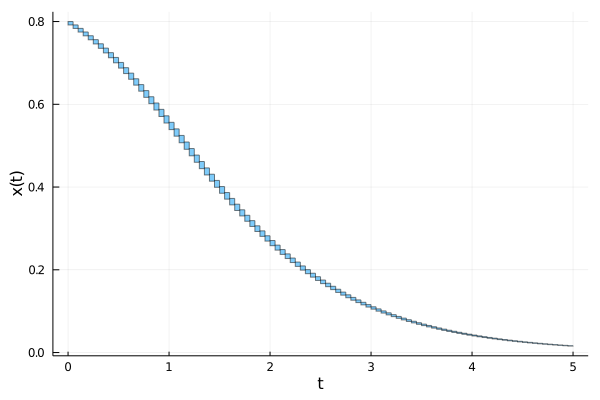

In [15]:
sol = solve(prob, tspan=(0., 5.0))

plot(sol, vars=(0, 1), xlab="t", ylab="x(t)")

In [16]:
# compute errors
e2 = error_bound_specabs(Interval(0.8), F1, F2, N=N)

# evalute error bounds for each time interval in the solution
E = [e2.(tspan(R)) for R in sol];

# symmetrize intervals
Esym = [symmetric_interval_hull(Interval(ei)) for ei in E];

In [17]:
# project solution on coordinate 1
sol1 = convert.(Interval, project(sol, 1))

# sum the solution with the error
sol1_total = [minkowski_sum(sol1[i], Esym[i]) for i in eachindex(sol1)];

# construct the flowpipe for visualization
sol1_fp = Flowpipe([ReachSet(sol1_total[i], tspan(R)) for (i, R) in enumerate(sol)]);

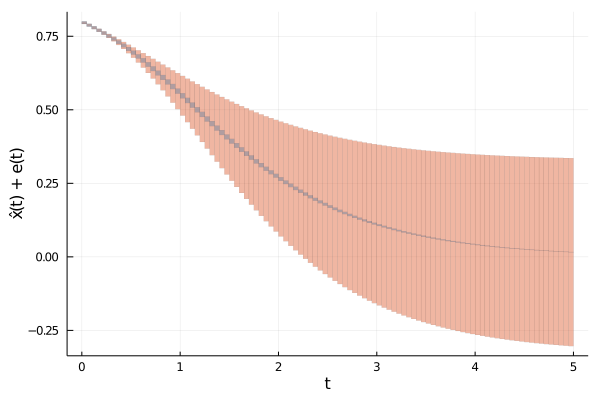

In [18]:
plot(sol, vars=(0, 1), xlab="t", ylab="̂x(t)", lw=0.1)
plot!(sol1_fp, vars=(0, 1), xlab="t", ylab="x̂(t) + e(t)", lw=0.1)

## Evaluation for different orders

In [19]:
function solve_carlin(x0::IA.Interval, A; N, T)
    
    ŷ0 = kron_pow_stack(x0, N)
    ŷ0 = IntervalBox(ŷ0)

    # assuming scalar ODE
    F1 = hcat(A[1, 1])
    F2 = hcat(A[1, 2])
    
    # solve continuous ODE
    prob = @ivp(ŷ' = Aŷ, ŷ(0) ∈ ŷ0)
    sol = solve(prob, tspan=(0., T))
    
    # compute errors
    e2 = error_bound_specabs(Interval(x0), F1, F2, N=N)

    # evalute error bounds for each time interval in the solution
    E = [e2.(tspan(R)) for R in sol];

    # symmetrize intervals
    Esym = [symmetric_interval_hull(Interval(ei)) for ei in E]

    # project solution on coordinate 1
    sol1 = convert.(Interval, project(sol, 1))

    # sum the solution with the error
    sol1_total = [minkowski_sum(sol1[i], Esym[i]) for i in eachindex(sol1)]

    # construct the flowpipe for visualization
    sol1_total_fp = Flowpipe([ReachSet(sol1_total[i], tspan(R)) for (i, R) in enumerate(sol)])
    
    return sol, sol1_total_fp
end

solve_carlin (generic function with 1 method)

In [20]:
Ap = N -> logistic(r=r, K=K, N=N);
x0 = IA.Interval(0.6, 0.6)
T = 5.0

@time out = [solve_carlin(x0, Ap(i); N=i, T) for i in 3:10];
soly = [o[1] for o in out]
sol = [o[2] for o in out];

 10.593564 seconds (14.84 M allocations: 775.553 MiB, 4.14% gc time)


In [21]:
length(sol)

8

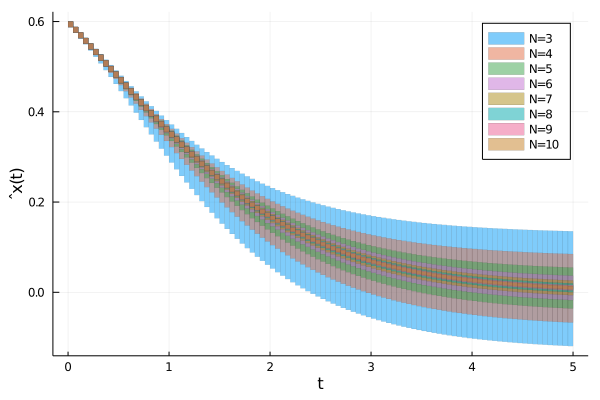

In [22]:
fig = plot(xlab="t", ylab="̂x(t)")
[plot!(fig, sol[i], vars=(0, 1), lab="N=$(2+i)", lw=0.1) for i in eachindex(sol)]
fig

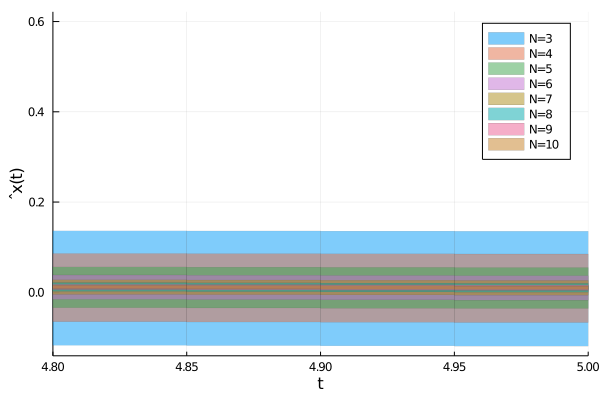

In [23]:
fig = plot(xlab="t", ylab="̂x(t)", xlims=(4.8, 5.0))
[plot!(fig, sol[i], vars=(0, 1), lab="N=$(2+i)", lw=0.1) for i in eachindex(sol)]
fig

## Comparison with the analytic solution

In [24]:
analytic(x0, a, b) = t -> x0 * a * exp(a * t) / (a + b * (1 - exp(a * t))*x0)

analytic (generic function with 1 method)

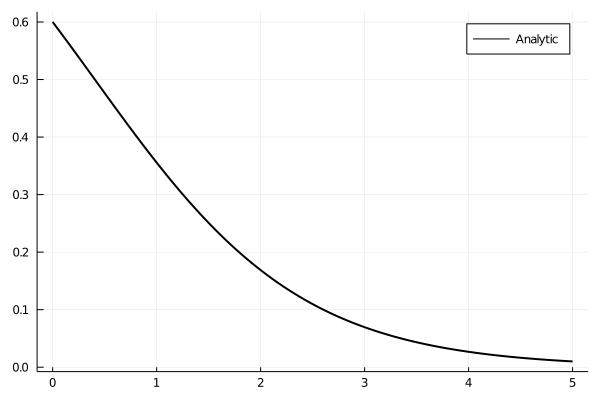

In [25]:
f = analytic(0.6, -1.0, 1.0)
dom = range(0.0, T, length=100)
plot(dom, f.(dom), lw=2.0, c=:black, lab="Analytic")

In [26]:
gr()

Plots.GRBackend()

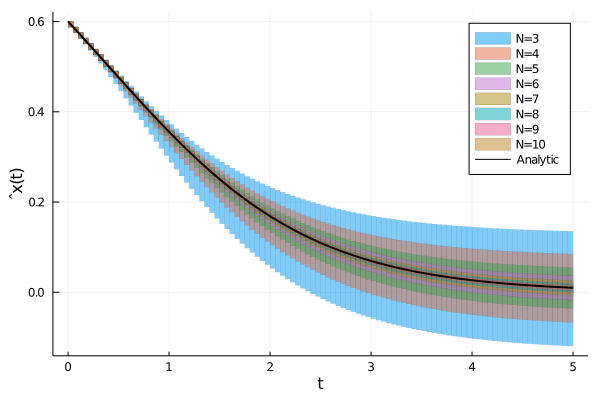

In [27]:
fig = plot(xlab="t", ylab="̂x(t)")
[plot!(fig, sol[i], vars=(0, 1), lab="N=$(2+i)", lw=0.1) for i in eachindex(sol)]
plot!(fig, dom, f.(dom), lw=2.0, c=:black, lab="Analytic")

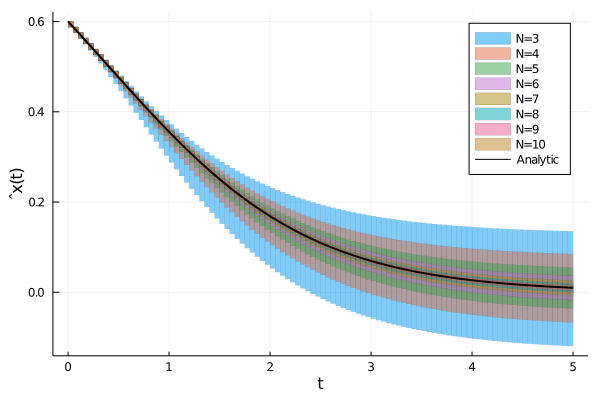

In [28]:
fig = plot(xlab="t", ylab="̂x(t)")
[plot!(fig, sol[i], vars=(0, 1), lab="N=$(2+i)", lw=0.1) for i in eachindex(sol)]
plot!(fig, dom, f.(dom), lw=2.0, c=:black, lab="Analytic")

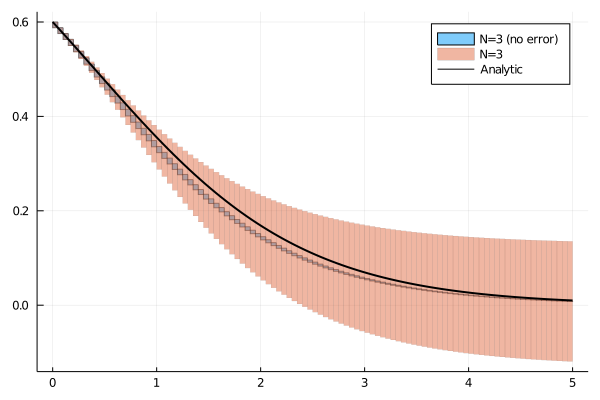

In [29]:
plot(soly[1], vars=(0, 1), lab="N=3 (no error)")
plot!(sol[1], vars=(0, 1), lab="N=3", lw=0.1)
plot!(dom, f.(dom), lw=2.0, c=:black, lab="Analytic")

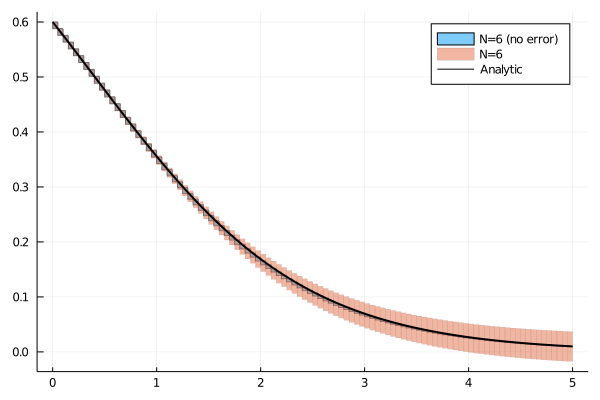

In [30]:
plot(soly[4], vars=(0, 1), lab="N=6 (no error)")
plot!(sol[4], vars=(0, 1), lab="N=6", lw=0.1)
plot!(dom, f.(dom), lw=2.0, c=:black, lab="Analytic")

## Computation for different R

Recall that $R = v_0 / K$ and the smaller this quantity is, the error bounds are better.

We consider two values, $R = 0.6$ and $R = 0.06$ (regime of weak nonlinearity). In both cases we consider that $v_0 = 0.6$ hence we take $K = 1.0$ and $K = 10.0$.

In [31]:
r

1.0

In [32]:
T = 5.0

5.0

In [33]:
x0 = IA.Interval(0.6)

[0.599999, 0.6]

In [34]:
@time sol_K1_noerr, sol_K1  = solve_carlin(x0, logistic(r=r, K=1, N=5); N=5, T)
@time sol_K10_noerr, sol_K10 = solve_carlin(x0, logistic(r=r, K=10, N=5); N=5, T);

  0.021862 seconds (23.23 k allocations: 1.347 MiB)
  0.001065 seconds (6.85 k allocations: 437.914 KiB)


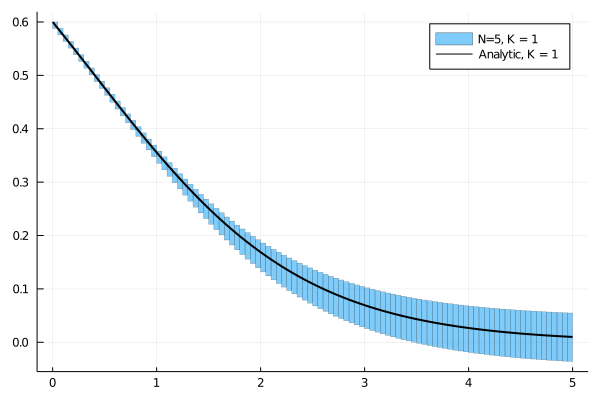

In [35]:
plot(sol_K1, vars=(0, 1), lab="N=5, K = 1", lw=0.3)
f_K1 = analytic(0.6, -1.0, 1.0/1)
dom = range(0.0, 5.0, length=200)
plot!(dom, f_K1.(dom), lw=2.0, c=:black, lab="Analytic, K = 1")

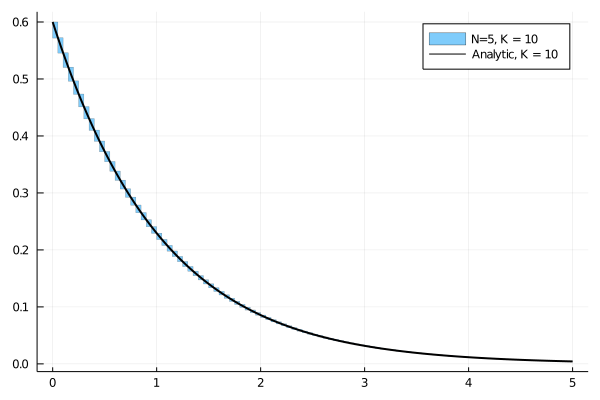

In [36]:
plot(sol_K10, vars=(0, 1), lab="N=5, K = 10", lw=0.3)
f_K10 = analytic(0.6, -1.0, 1/10)
plot!(dom, f_K10.(dom), lw=2.0, c=:black, lab="Analytic, K = 10")

## Comparison with TMJets

In [37]:
@taylorize function logistic_K1!(dx, x, p, t)
    local r = 1.0
    local K = 1.0
    dx[1] = -r*x[1] + (r/K)*x[1]^2
end

@taylorize function logistic_K10!(dx, x, p, t)
    local r = 1.0
    local K = 10.0
    dx[1] = -r*x[1] + (r/K)*x[1]^2
end

 15.144407 seconds (30.71 M allocations: 1.447 GiB, 4.95% gc time)


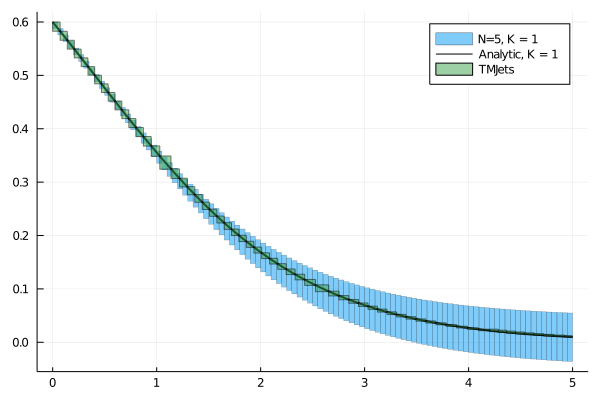

In [38]:
# K = 1
prob = @ivp(x' = logistic_K1!(x), x(0) ∈ Singleton([0.6]), dim=1)
@time sol = solve(prob, T=5.0, alg=TMJets(abs_tol=1e-12))

fig_K1 = plot()
plot!(fig_K1, sol_K1, vars=(0, 1), lab="N=5, K = 1", lw=0.3)
f_K1 = analytic(0.6, -1.0, 1.0/1)
dom = range(0.0, 5.0, length=200)
plot!(fig_K1, dom, f_K1.(dom), lw=2.0, c=:black, lab="Analytic, K = 1")
plot!(fig_K1, sol, vars=(0, 1), lab="TMJets")

we're solving: $x' = -x + x$

- TMJets : 700ms

- CARLIN : 2ms

### K = 10

  2.861432 seconds (3.67 M allocations: 218.282 MiB, 1.87% gc time)


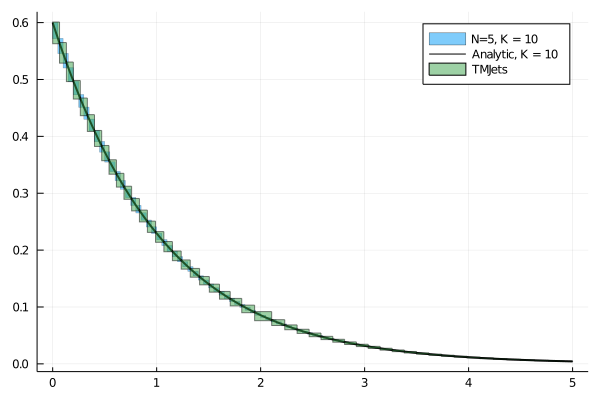

In [39]:
# K = 10
prob = @ivp(x' = logistic_K10!(x), x(0) ∈ Singleton([0.6]), dim=1)
@time sol = solve(prob, T=5.0, alg=TMJets(abs_tol=1e-12))

plot(sol_K10, vars=(0, 1), lab="N=5, K = 10", lw=0.3)
dom = range(0.0, 5.0, length=200)
plot!(dom, f_K10.(dom), lw=2.0, c=:black, lab="Analytic, K = 10")

plot!(sol, vars=(0, 1), lab="TMJets")

In [40]:
1.0/10

0.1

we're solving: $x' = -x + 0.1x$

- TMJets : 575ms

- CARLIN : 2ms

## Solution method with resets, K = 10

In [41]:
F1 = sparse(hcat(-1.0))
F2 = sparse(hcat(1.0))
X0 = convert(Hyperrectangle, Interval(0.5, 0.6))

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.55], [0.04999999999999999])

In [53]:
@time sol_res1, sol_err_res1 = _solve_CARLIN_LGG09(X0, F1, F2;
                       resets=0, N=4, T=5.0, δ=1e-2);

  0.029882 seconds (45.17 k allocations: 2.699 MiB, 65.51% gc time)


In [51]:
tspan.(sol_err_res1)

500-element Array{IntervalArithmetic.Interval{Float64},1}:
 [0, 0.0100001]
    [0.01, 0.0200001]
    [0.02, 0.0300001]
    [0.0299999, 0.0400001]
    [0.0399999, 0.0500001]
    [0.0499999, 0.0600001]
    [0.0599999, 0.0700001]
    [0.0699999, 0.0800001]
    [0.0799999, 0.0900001]
    [0.0899999, 0.100001]
    [0.0999999, 0.110001]
    [0.109999, 0.120001]
    [0.119999, 0.130001]
     ⋮
    [4.87999, 4.89001]
    [4.88999, 4.90001]
    [4.89999, 4.91001]
    [4.90999, 4.92001]
    [4.91999, 4.93001]
    [4.92999, 4.94001]
    [4.93999, 4.95001]
    [4.94999, 4.96001]
    [4.95999, 4.97001]
    [4.96999, 4.98001]
    [4.97999, 4.99001]
    [4.98999, 5.00001]

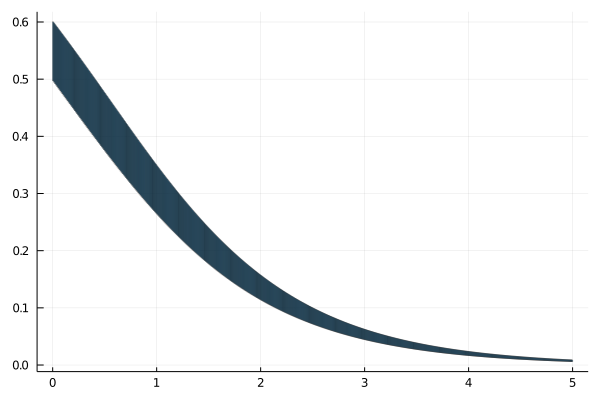

In [55]:
plot(sol_res1, vars=(0, 1))

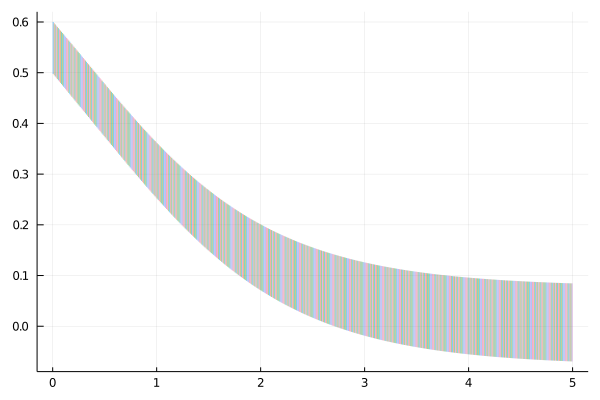

In [52]:
fig = plot()
[plot!(fig, si, vars=(0, 1), lw=0.0) for si in sol_err_res1]
fig

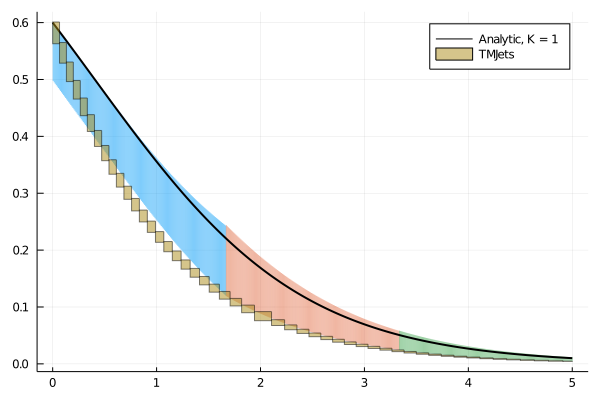

In [45]:

# K = 1
#plot!(fig, sol_K1, vars=(0, 1), lab="N=5, K = 1", lw=0.3)
f_K1 = analytic(0.6, -1.0, 1.0/1)
dom = range(0.0, 5.0, length=200)
plot!(fig, dom, f_K1.(dom), lw=2.0, c=:black, lab="Analytic, K = 1")
plot!(fig, sol, vars=(0, 1), lab="TMJets")

fig

## Figure of solution for different $N$ (no resets)